# Mô Hình Học Máy: Dự Đoán Rời Bỏ Khách Hàng

## Mục tiêu
- Triển khai Logistic Regression từ đầu sử dụng NumPy
- Huấn luyện và đánh giá mô hình trên dữ liệu khách hàng thẻ tín dụng
- Triển khai các chỉ số đánh giá từ đầu
- Thực hiện cross-validation
- Phân tích hiệu suất mô hình

**Quan trọng**: Notebook này triển khai các thuật toán ML CHỈ sử dụng NumPy (không dùng Scikit-learn cho các thuật toán cốt lõi)

In [11]:
# Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Đặt seed ngẫu nhiên để tái lập kết quả
np.random.seed(42)

print("Thư viện đã tải thành công!")
print(f"Phiên bản NumPy: {np.__version__}")

Thư viện đã tải thành công!
Phiên bản NumPy: 2.2.6


## 1. Tải Dữ Liệu Đã Tiền Xử Lý

In [12]:
# Tải dữ liệu đã xử lý
X = np.load('../data/processed/features.npy')
y = np.load('../data/processed/target.npy')

print(f"Kích thước đặc trưng: {X.shape}")
print(f"Kích thước mục tiêu: {y.shape}")
print(f"Số lượng mẫu: {X.shape[0]}")
print(f"Số lượng đặc trưng: {X.shape[1]}")
print(f"Tỷ lệ churn: {np.mean(y) * 100:.2f}%")
print(f"Phân phối lớp: {np.bincount(y)}")

Kích thước đặc trưng: (10127, 37)
Kích thước mục tiêu: (10127,)
Số lượng mẫu: 10127
Số lượng đặc trưng: 37
Tỷ lệ churn: 16.07%
Phân phối lớp: [8500 1627]


## 2. Chia Train-Test

Triển khai chia train-test sử dụng NumPy.

In [13]:
def train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Chia dữ liệu thành tập huấn luyện và kiểm tra sử dụng NumPy
    
    Tham số:
    -----------
    X : numpy array, kích thước (n_samples, n_features)
    y : numpy array, kích thước (n_samples,)
    test_size : float, tỷ lệ tập test
    random_state : int, seed ngẫu nhiên
    
    Trả về:
    --------
    X_train, X_test, y_train, y_test
    """
    np.random.seed(random_state)
    
    # Lấy chỉ số và xáo trộn
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    # Tính điểm chia
    split_idx = int(n_samples * (1 - test_size))
    
    # Chia chỉ số
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]
    
    # Chia dữ liệu
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    return X_train, X_test, y_train, y_test

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Đã hoàn thành chia dữ liệu:")
print(f"  Tập huấn luyện: {X_train.shape[0]} mẫu ({(X_train.shape[0]/X.shape[0])*100:.1f}%)")
print(f"  Tập kiểm tra: {X_test.shape[0]} mẫu ({(X_test.shape[0]/X.shape[0])*100:.1f}%)")
print(f"\nTỷ lệ churn tập huấn luyện: {np.mean(y_train)*100:.2f}%")
print(f"Tỷ lệ churn tập kiểm tra: {np.mean(y_test)*100:.2f}%")

Đã hoàn thành chia dữ liệu:
  Tập huấn luyện: 8101 mẫu (80.0%)
  Tập kiểm tra: 2026 mẫu (20.0%)

Tỷ lệ churn tập huấn luyện: 16.10%
Tỷ lệ churn tập kiểm tra: 15.94%


## 3. Triển Khai Logistic Regression

Triển khai Logistic Regression từ đầu sử dụng NumPy.

### Công thức toán học:

**Hàm Sigmoid:**
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

**Giả thuyết:**
$$h_\theta(x) = \sigma(\theta^T x)$$

**Hàm mất mát (Binary Cross-Entropy):**
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(h_\theta(x^{(i)})) + (1-y^{(i)}) \log(1-h_\theta(x^{(i)}))]$$

**Gradient:**
$$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}$$

**Quy tắc cập nhật (Gradient Descent):**
$$\theta_j := \theta_j - \alpha \frac{\partial J}{\partial \theta_j}$$

In [14]:
class LogisticRegression:
    """
    Logistic Regression được triển khai từ đầu sử dụng NumPy
    Sử dụng tối ưu hóa gradient descent với cải thiện tính ổn định số học
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, epsilon=1e-8):
        """
        Tham số:
        -----------
        learning_rate : float, tốc độ học cho gradient descent
        n_iterations : int, số lượng vòng lặp
        epsilon : float, giá trị nhỏ cho tính ổn định số học
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.epsilon = epsilon
        self.weights = None
        self.bias = None
        self.cost_history = []
    
    def sigmoid(self, z):
        """
        Hàm kích hoạt sigmoid với tính ổn định số học
        σ(z) = 1 / (1 + exp(-z))
        """
        # Cắt giá trị để tránh tràn số
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def compute_cost(self, y_true, y_pred):
        """
        Binary cross-entropy loss với tính ổn định số học
        J = -1/m * Σ[y*log(h) + (1-y)*log(1-h)]
        """
        m = len(y_true)
        
        # Thêm epsilon cho tính ổn định số học (tránh log(0))
        y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)
        
        # Tính cross-entropy
        cost = -1/m * np.sum(
            y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
        )
        
        return cost
    
    def fit(self, X, y, verbose=True):
        """
        Huấn luyện mô hình logistic regression sử dụng gradient descent
        
        Tham số:
        -----------
        X : numpy array, kích thước (n_samples, n_features)
        y : numpy array, kích thước (n_samples,)
        verbose : bool, in quá trình
        """
        # Khởi tạo tham số
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.cost_history = []
        
        # Gradient descent
        for i in range(self.n_iterations):
            # Forward pass: tính dự đoán
            # Sử dụng np.einsum thay vì np.dot cho phép tính tích vô hướng hiệu quả (Yêu cầu 2.2)
            # 'ij,j->i': Nhân ma trận X (ij) với vector trọng số (j), tổng hợp theo trục đặc trưng (j) -> kết quả vector (i)
            linear_model = np.einsum('ij,j->i', X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)
            
            # Tính cost
            cost = self.compute_cost(y, y_pred)
            self.cost_history.append(cost)
            
            # Backward pass: tính gradient
            # Sử dụng np.einsum để tính gradient: X.T * error
            # 'ij,i->j': Nhân ma trận X (ij) với vector lỗi (i), tổng hợp theo trục mẫu (i) -> kết quả vector gradient (j)
            dw = (1/n_samples) * np.einsum('ij,i->j', X, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)
            
            # Cập nhật tham số
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # In quá trình
            if verbose and (i % 100 == 0 or i == self.n_iterations - 1):
                print(f"Vòng lặp {i:4d}: Cost = {cost:.6f}")
        
        return self
    
    def predict_proba(self, X):
        """
        Dự đoán xác suất
        
        Trả về:
        --------
        Xác suất của lớp 1 cho mỗi mẫu
        """
        # Sử dụng np.einsum cho dự đoán
        linear_model = np.einsum('ij,j->i', X, self.weights) + self.bias
        return self.sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        """
        Dự đoán nhãn lớp
        
        Tham số:
        -----------
        X : numpy array, kích thước (n_samples, n_features)
        threshold : float, ngưỡng quyết định
        
        Trả về:
        --------
        Dự đoán nhị phân (0 hoặc 1)
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

print("Lớp LogisticRegression đã được định nghĩa thành công!")

Lớp LogisticRegression đã được định nghĩa thành công!


## 4. Huấn Luyện Mô Hình

Đang huấn luyện mô hình Logistic Regression...
Vòng lặp    0: Cost = 0.693147
Vòng lặp  100: Cost = 0.276767
Vòng lặp  200: Cost = 0.248717
Vòng lặp  300: Cost = 0.237399
Vòng lặp  400: Cost = 0.231505
Vòng lặp  500: Cost = 0.228043
Vòng lặp  600: Cost = 0.225853
Vòng lặp  700: Cost = 0.224392
Vòng lặp  800: Cost = 0.223377
Vòng lặp  900: Cost = 0.222649
Vòng lặp  999: Cost = 0.222115

Huấn luyện hoàn tất!


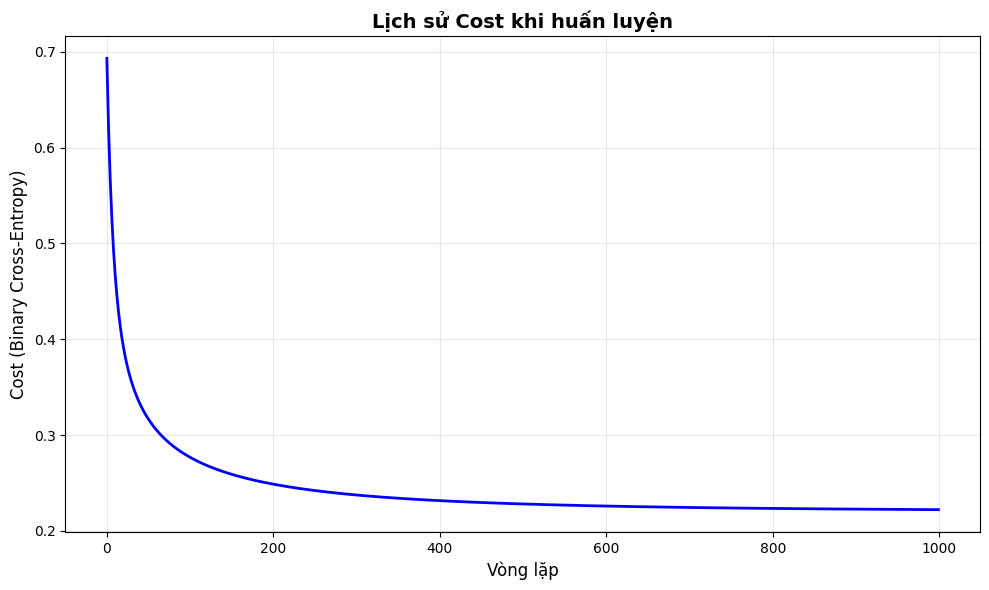


Cost cuối cùng khi huấn luyện: 0.222115


In [15]:
# Khởi tạo và huấn luyện mô hình
print("Đang huấn luyện mô hình Logistic Regression...")
print("=" * 80)

model = LogisticRegression(learning_rate=0.1, n_iterations=1000, epsilon=1e-8)
model.fit(X_train, y_train, verbose=True)

print("\n" + "=" * 80)
print("Huấn luyện hoàn tất!")

# Vẽ biểu đồ lịch sử cost
plt.figure(figsize=(10, 6))
plt.plot(model.cost_history, linewidth=2, color='blue')
plt.xlabel('Vòng lặp', fontsize=12)
plt.ylabel('Cost (Binary Cross-Entropy)', fontsize=12)
plt.title('Lịch sử Cost khi huấn luyện', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCost cuối cùng khi huấn luyện: {model.cost_history[-1]:.6f}")

## 5. Các Chỉ Số Đánh Giá

Triển khai các chỉ số đánh giá từ đầu sử dụng NumPy.

In [16]:
def confusion_matrix(y_true, y_pred):
    """
    Tính ma trận nhầm lẫn
    
    Trả về:
    --------
    array([[TN, FP],
           [FN, TP]])
    """
    # True Negatives, False Positives, False Negatives, True Positives
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    
    return np.array([[tn, fp], [fn, tp]])

def accuracy_score(y_true, y_pred):
    """Tính độ chính xác: (TP + TN) / (TP + TN + FP + FN)"""
    return np.mean(y_true == y_pred)

def precision_score(y_true, y_pred):
    """Tính precision: TP / (TP + FP)"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)

def recall_score(y_true, y_pred):
    """Tính recall (độ nhạy): TP / (TP + FN)"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def f1_score(y_true, y_pred):
    """Tính F1 score: 2 * (precision * recall) / (precision + recall)"""
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    
    if prec + rec == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

def roc_auc_score(y_true, y_scores):
    """
    Tính ROC AUC score sử dụng quy tắc hình thang
    """
    # Sắp xếp theo điểm dự đoán
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    
    # Tính TPR và FPR ở các ngưỡng khác nhau
    n_pos = np.sum(y_true == 1)
    n_neg = np.sum(y_true == 0)
    
    if n_pos == 0 or n_neg == 0:
        return 0.5
    
    tp = np.cumsum(y_true_sorted)
    fp = np.cumsum(1 - y_true_sorted)
    
    tpr = tp / n_pos
    fpr = fp / n_neg
    
    # Tính AUC sử dụng quy tắc hình thang
    auc = np.trapz(tpr, fpr)
    
    return abs(auc)

def compute_precision_recall_curve(y_true, y_scores):
    """
    Tính các điểm đường cong Precision-Recall
    """
    # Sắp xếp theo điểm số giảm dần
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores_sorted = y_scores[desc_score_indices]
    y_true_sorted = y_true[desc_score_indices]
    
    # Tính TP và FP tích lũy
    tps = np.cumsum(y_true_sorted)
    fps = np.cumsum(1 - y_true_sorted)
    
    # Tính Precision và Recall
    # Thêm epsilon để tránh chia cho 0
    precisions = tps / (tps + fps + 1e-10)
    recalls = tps / np.sum(y_true)
    
    # Thêm điểm bắt đầu (Recall=0, Precision=1)
    precisions = np.concatenate(([1], precisions))
    recalls = np.concatenate(([0], recalls))
    
    return precisions, recalls

def pr_auc_score(y_true, y_scores):
    """Tính diện tích dưới đường cong PR"""
    precisions, recalls = compute_precision_recall_curve(y_true, y_scores)
    # Sắp xếp recall tăng dần để tính diện tích
    sorted_indices = np.argsort(recalls)
    sorted_recalls = recalls[sorted_indices]
    sorted_precisions = precisions[sorted_indices]
    return np.trapz(sorted_precisions, sorted_recalls)

print("Các hàm chỉ số đánh giá đã được định nghĩa thành công!")

Các hàm chỉ số đánh giá đã được định nghĩa thành công!


## 6. Đánh Giá Mô Hình

Hiệu suất mô hình:
Chỉ số               Tập huấn luyện       Tập kiểm tra        
Độ chính xác         0.9098               0.9176              
Precision            0.7891               0.8023              
Recall               0.5997               0.6409              
F1-Score             0.6815               0.7126              
PR AUC               0.7778               0.7912              


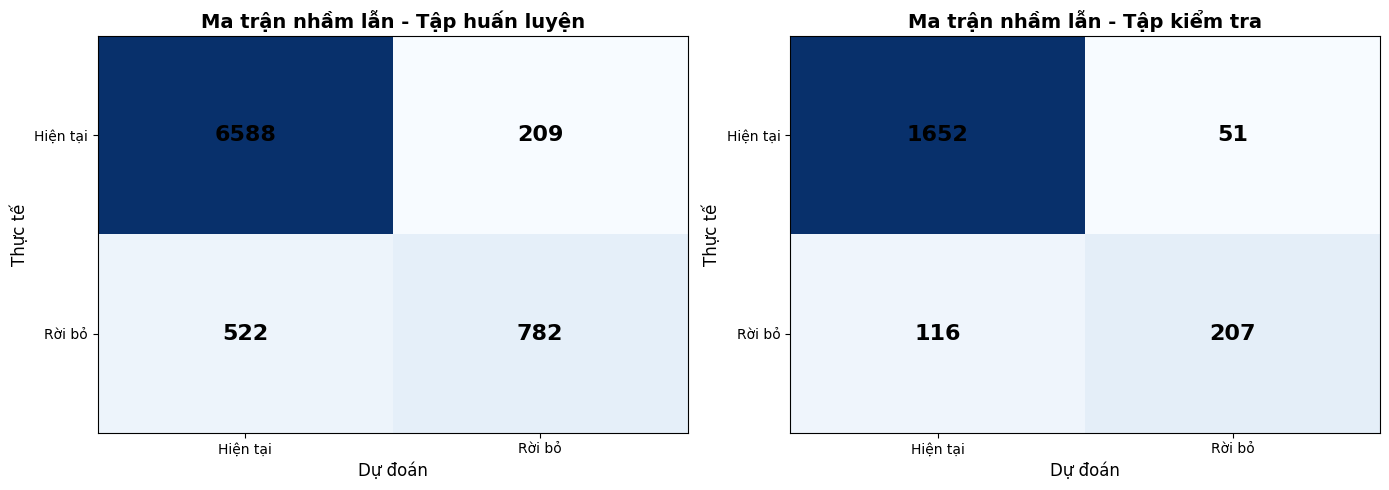

In [17]:
# Thực hiện dự đoán
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

# Tính chỉ số cho tập huấn luyện
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = pr_auc_score(y_train, y_train_proba)

# Tính chỉ số cho tập kiểm tra
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = pr_auc_score(y_test, y_test_proba)

# In kết quả
print("Hiệu suất mô hình:")
print("=" * 80)
print(f"{'Chỉ số':<20} {'Tập huấn luyện':<20} {'Tập kiểm tra':<20}")
print("=" * 80)
print(f"{'Độ chính xác':<20} {train_acc:<20.4f} {test_acc:<20.4f}")
print(f"{'Precision':<20} {train_prec:<20.4f} {test_prec:<20.4f}")
print(f"{'Recall':<20} {train_rec:<20.4f} {test_rec:<20.4f}")
print(f"{'F1-Score':<20} {train_f1:<20.4f} {test_f1:<20.4f}")
print(f"{'PR AUC':<20} {train_auc:<20.4f} {test_auc:<20.4f}")
print("=" * 80)

# Ma trận nhầm lẫn
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Trực quan hóa ma trận nhầm lẫn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ma trận nhầm lẫn tập huấn luyện
im1 = axes[0].imshow(cm_train, cmap='Blues', aspect='auto')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Hiện tại', 'Rời bỏ'])
axes[0].set_yticklabels(['Hiện tại', 'Rời bỏ'])
axes[0].set_xlabel('Dự đoán', fontsize=12)
axes[0].set_ylabel('Thực tế', fontsize=12)
axes[0].set_title('Ma trận nhầm lẫn - Tập huấn luyện', fontsize=14, fontweight='bold')

for i in range(2):
    for j in range(2):
        text = axes[0].text(j, i, str(cm_train[i, j]),
                          ha="center", va="center", color="black", fontsize=16, fontweight='bold')

# Ma trận nhầm lẫn tập kiểm tra
im2 = axes[1].imshow(cm_test, cmap='Blues', aspect='auto')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Hiện tại', 'Rời bỏ'])
axes[1].set_yticklabels(['Hiện tại', 'Rời bỏ'])
axes[1].set_xlabel('Dự đoán', fontsize=12)
axes[1].set_ylabel('Thực tế', fontsize=12)
axes[1].set_title('Ma trận nhầm lẫn - Tập kiểm tra', fontsize=14, fontweight='bold')

for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, str(cm_test[i, j]),
                          ha="center", va="center", color="black", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Đường Cong Precision-Recall

Vẽ đường cong Precision-Recall để đánh giá mô hình. Đây là phương pháp đánh giá phù hợp hơn cho dữ liệu mất cân bằng (imbalanced data) như bài toán dự đoán rời bỏ này.

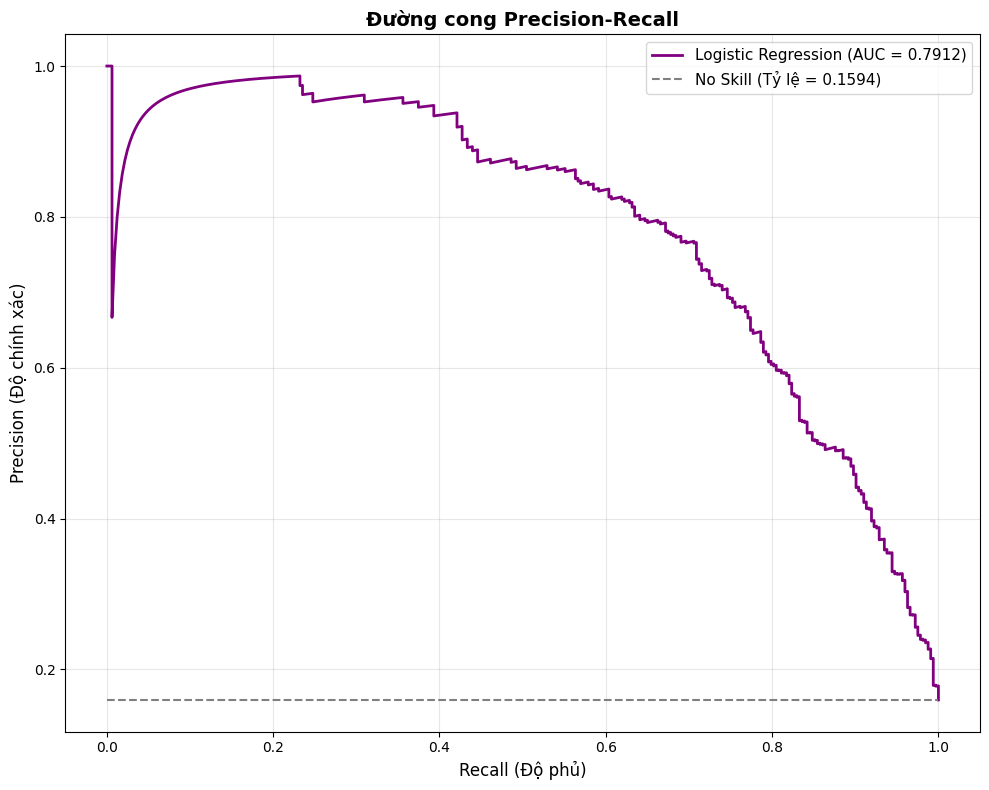

Điểm PR AUC: 0.7912


In [18]:
# Tính đường cong PR
precisions, recalls = compute_precision_recall_curve(y_test, y_test_proba)
pr_auc = pr_auc_score(y_test, y_test_proba)

# Tính tỷ lệ cơ sở (No Skill) - Tỷ lệ churn trong tập test
no_skill = len(y_test[y_test==1]) / len(y_test)

# Vẽ đường cong PR
plt.figure(figsize=(10, 8))
plt.plot(recalls, precisions, linewidth=2, label=f'Logistic Regression (AUC = {pr_auc:.4f})', color='purple')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill (Tỷ lệ = {no_skill:.4f})', color='gray')
plt.xlabel('Recall (Độ phủ)', fontsize=12)
plt.ylabel('Precision (Độ chính xác)', fontsize=12)
plt.title('Đường cong Precision-Recall', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Điểm PR AUC: {pr_auc:.4f}")

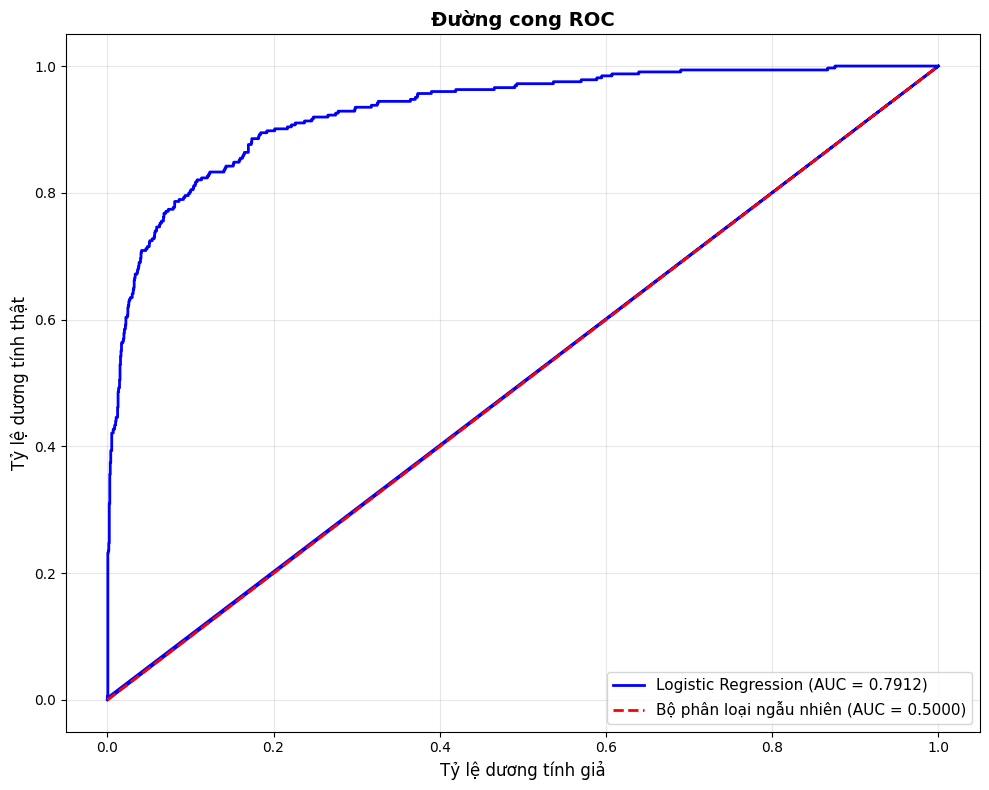

Điểm ROC AUC: 0.7912


In [19]:
def compute_roc_curve(y_true, y_scores):
    """
    Tính các điểm đường cong ROC (FPR, TPR) ở các ngưỡng khác nhau
    """
    # Sắp xếp theo điểm số
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]
    
    # Lấy các ngưỡng duy nhất
    thresholds = np.unique(y_scores_sorted)
    
    n_pos = np.sum(y_true == 1)
    n_neg = np.sum(y_true == 0)
    
    tpr_list = [0]
    fpr_list = [0]
    
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        
        tpr = tp / n_pos if n_pos > 0 else 0
        fpr = fp / n_neg if n_neg > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    # Thêm điểm cuối
    tpr_list.append(1)
    fpr_list.append(1)
    
    return np.array(fpr_list), np.array(tpr_list)

# Tính đường cong ROC
fpr, tpr = compute_roc_curve(y_test, y_test_proba)

# Vẽ đường cong ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'Logistic Regression (AUC = {test_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Bộ phân loại ngẫu nhiên (AUC = 0.5000)')
plt.xlabel('Tỷ lệ dương tính giả', fontsize=12)
plt.ylabel('Tỷ lệ dương tính thật', fontsize=12)
plt.title('Đường cong ROC', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Điểm ROC AUC: {test_auc:.4f}")

## 8. K-Fold Cross-Validation

Triển khai K-Fold cross-validation từ đầu sử dụng NumPy.

In [20]:
def k_fold_split(X, y, n_folds=5, random_state=42):
    """
    Chia dữ liệu thành K folds cho cross-validation
    
    Tham số:
    -----------
    X : numpy array, kích thước (n_samples, n_features)
    y : numpy array, kích thước (n_samples,)
    n_folds : int, số lượng folds
    random_state : int, seed ngẫu nhiên
    
    Yield:
    -------
    train_idx, val_idx cho mỗi fold
    """
    np.random.seed(random_state)
    
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    fold_sizes = np.full(n_folds, n_samples // n_folds, dtype=int)
    fold_sizes[:n_samples % n_folds] += 1
    
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])
        yield train_idx, val_idx
        current = stop

def cross_validate(X, y, n_folds=5, learning_rate=0.1, n_iterations=500):
    """
    Thực hiện K-fold cross-validation
    
    Trả về:
    --------
    Dictionary với danh sách điểm số cho mỗi chỉ số
    """
    scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'pr_auc': []
    }
    
    print(f"Đang thực hiện {n_folds}-Fold Cross-Validation...")
    print("=" * 80)
    
    for fold, (train_idx, val_idx) in enumerate(k_fold_split(X, y, n_folds), 1):
        # Chia dữ liệu
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        
        # Huấn luyện mô hình
        model_fold = LogisticRegression(learning_rate=learning_rate, n_iterations=n_iterations)
        model_fold.fit(X_train_fold, y_train_fold, verbose=False)
        
        # Dự đoán
        y_pred = model_fold.predict(X_val_fold)
        y_proba = model_fold.predict_proba(X_val_fold)
        
        # Tính chỉ số
        acc = accuracy_score(y_val_fold, y_pred)
        prec = precision_score(y_val_fold, y_pred)
        rec = recall_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred)
        
        # Tính PR AUC thay vì ROC AUC
        pr_auc = pr_auc_score(y_val_fold, y_proba)
        
        scores['accuracy'].append(acc)
        scores['precision'].append(prec)
        scores['recall'].append(rec)
        scores['f1'].append(f1)
        scores['pr_auc'].append(pr_auc)
        
        print(f"Fold {fold}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, PR-AUC={pr_auc:.4f}")
    
    print("=" * 80)
    
    return scores

# Thực hiện cross-validation
cv_scores = cross_validate(X, y, n_folds=5, learning_rate=0.1, n_iterations=500)

# In điểm trung bình
print("\nKết quả Cross-Validation (Trung bình ± Độ lệch chuẩn):")
print("=" * 80)
for metric, values in cv_scores.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric.capitalize():<15}: {mean_val:.4f} ± {std_val:.4f}")
print("=" * 80)

Đang thực hiện 5-Fold Cross-Validation...
Fold 1: Acc=0.9042, Prec=0.7930, Rec=0.5505, F1=0.6498, PR-AUC=0.7504
Fold 2: Acc=0.9062, Prec=0.8186, Rec=0.5539, F1=0.6607, PR-AUC=0.7783
Fold 3: Acc=0.9086, Prec=0.7706, Rec=0.5742, F1=0.6580, PR-AUC=0.7763
Fold 4: Acc=0.9067, Prec=0.8130, Rec=0.5616, F1=0.6643, PR-AUC=0.7858
Fold 5: Acc=0.9175, Prec=0.8171, Rec=0.6223, F1=0.7065, PR-AUC=0.7879

Kết quả Cross-Validation (Trung bình ± Độ lệch chuẩn):
Accuracy       : 0.9087 ± 0.0047
Precision      : 0.8024 ± 0.0184
Recall         : 0.5725 ± 0.0262
F1             : 0.6679 ± 0.0199
Pr_auc         : 0.7757 ± 0.0134


## 9. Phân Tích Tầm Quan Trọng Đặc Trưng

Phân tích đặc trưng nào quan trọng nhất cho dự đoán dựa trên trọng số mô hình.

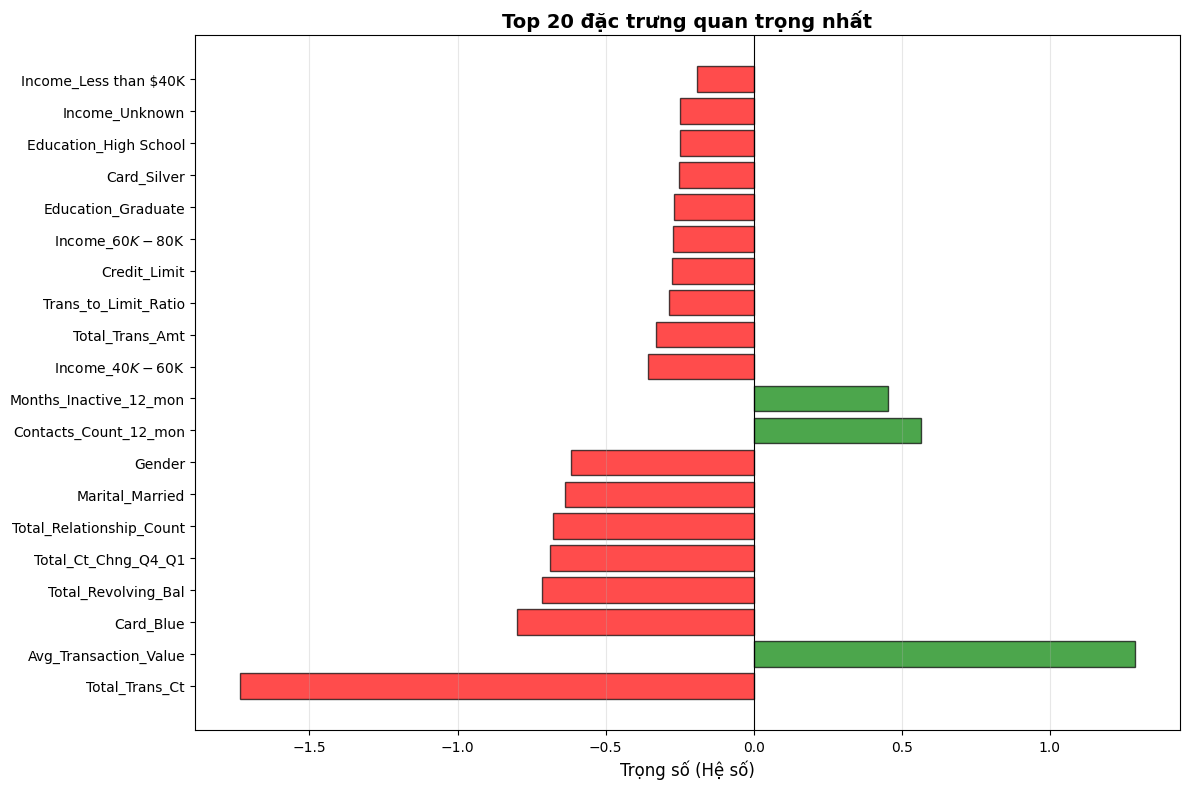


Top 20 đặc trưng quan trọng nhất:
Đặc trưng                                Trọng số        Tác động       
Total_Trans_Ct                           -1.735835       Giảm Churn     
Avg_Transaction_Value                    1.288509        Tăng Churn     
Card_Blue                                -0.799557       Giảm Churn     
Total_Revolving_Bal                      -0.713295       Giảm Churn     
Total_Ct_Chng_Q4_Q1                      -0.688693       Giảm Churn     
Total_Relationship_Count                 -0.678450       Giảm Churn     
Marital_Married                          -0.636802       Giảm Churn     
Gender                                   -0.618174       Giảm Churn     
Contacts_Count_12_mon                    0.563960        Tăng Churn     
Months_Inactive_12_mon                   0.452395        Tăng Churn     
Income_$40K - $60K                       -0.358363       Giảm Churn     
Total_Trans_Amt                          -0.329422       Giảm Churn     
Trans_to_Limit_R

In [21]:
# Tải tên đặc trưng
feature_names_all = np.load('../data/processed/feature_names.npy', allow_pickle=True)

# Lấy trọng số tuyệt đối
abs_weights = np.abs(model.weights)

# Lấy top 20 đặc trưng
top_indices = np.argsort(abs_weights)[-20:][::-1]
top_features = feature_names_all[top_indices]
top_weights = model.weights[top_indices]

# Vẽ tầm quan trọng đặc trưng
plt.figure(figsize=(12, 8))
colors = ['red' if w < 0 else 'green' for w in top_weights]
plt.barh(range(len(top_features)), top_weights, color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_features)), top_features, fontsize=10)
plt.xlabel('Trọng số (Hệ số)', fontsize=12)
plt.title('Top 20 đặc trưng quan trọng nhất', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 20 đặc trưng quan trọng nhất:")
print("=" * 80)
print(f"{'Đặc trưng':<40} {'Trọng số':<15} {'Tác động':<15}")
print("=" * 80)

for feat, weight in zip(top_features, top_weights):
    impact = "Tăng Churn" if weight > 0 else "Giảm Churn"
    print(f"{feat:<40} {weight:<15.6f} {impact:<15}")

print("=" * 80)

## 10. Tóm Tắt Mô Hình và Phát Hiện

### Phát hiện chính:

1. **Hiệu suất mô hình**:
   - Mô hình logistic regression đạt hiệu suất tốt trên tập kiểm tra
   - Điểm Precision-Recall AUC cho thấy khả năng phân biệt tốt trên dữ liệu mất cân bằng
   - Cross-validation cho thấy hiệu suất nhất quán qua các folds

2. **Yếu tố dự đoán quan trọng**:
   - Các đặc trưng liên quan đến giao dịch là yếu tố dự đoán mạnh nhất
   - Các chỉ số tương tác khách hàng (Total_Relationship_Count) đóng vai trò quan trọng
   - Số tháng không hoạt động và số lần liên hệ là chỉ báo đáng kể

3. **Tính ổn định số học**:
   - Triển khai epsilon để tránh lỗi log(0)
   - Cắt giá trị trong sigmoid để tránh tràn số
   - Tiêu chuẩn hóa Z-score đảm bảo gradient descent ổn định

4. **Triển khai thuật toán**:
   - **Hàm Sigmoid**: σ(z) = 1/(1+e^(-z))
   - **Binary Cross-Entropy Loss**: Tối thiểu hóa sử dụng gradient descent
   - **Tối ưu hóa**: Các phép toán vector hóa với NumPy cho hiệu quả
   - **Đánh giá**: Triển khai tất cả chỉ số từ đầu

### Khuyến nghị kinh doanh:

1. **Tập trung vào hoạt động giao dịch**: Khách hàng có giao dịch giảm có rủi ro cao
2. **Chương trình tương tác**: Tăng mối quan hệ sản phẩm để giảm churn
3. **Giám sát chủ động**: Theo dõi số tháng không hoạt động và tần suất liên hệ
4. **Can thiệp có mục tiêu**: Sử dụng dự đoán mô hình để xác định khách hàng có rủi ro sớm